In [232]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [251]:
def optimal_weights(cov):
    n = cov.shape[0]
    prec = np.linalg.inv(cov)
    denom = np.matmul(np.matmul(np.ones(n), prec), np.ones(n))
    return np.matmul(prec, np.ones(n)) / denom

In [253]:
def sample_estimate(pastRet):
    return np.cov(pastRet.T)

In [302]:
def OOS_rets(w, outret):
    total_ret = outret + 1
    cum_ret = np.cumprod(total_ret, axis=0)[-1,:]
    cum_ret -= 1
    #print(np.mean(cum_ret) * 252)
    return np.dot(w, cum_ret)

In [326]:
def get_OOS_rets(cov_estimator, meta_info):
    ret, univ, tradeidx = meta_info
    rets = []
    for h in range(100):
        N = 250 #Number of stocks
        T = 500 #lookback
        P = 1 #lookahead
        universe = univ[h,:N]
        today = tradeidx[h][0]
        pastPeriod = range(today-T, today)
        pastRet = ret[pastPeriod][:, universe]
        investPeriod = range(today, today + P)
        outRet = ret[investPeriod][:, universe]
        
        cov = cov_estimator(pastRet)
        w = optimal_weights(cov)

        curret = OOS_rets(w, outRet) #slightly shrunk sample
        
        rets.append(curret)
    return rets

In [319]:
ret = pd.read_csv('ret.csv', header = None).values
univ = pd.read_csv('topMV95.csv', header = None).values
dates = pd.read_csv('mydatestr.txt', header = None, parse_dates = [0])
tradeidx = pd.read_csv('investDateIdx.csv', header = None).values
ret[np.isnan(ret)] = 0
ret = ret / 100 #I think ret is in percent

In [323]:
meta_info = [ret, univ, tradeidx]

In [314]:
def shrunk_sample_cov(lamb):
    return lambda pastRet: np.cov(pastRet.T) + np.eye(pastRet.shape[1]) * lamb

In [328]:
def equal_weight(pastRet):
    _, N = pastRet.shape
    return np.eye(N)

In [329]:
equal_rets = get_OOS_rets(equal_weight, meta_info)

In [330]:
shrunk_10 = get_OOS_rets(shrunk_sample_cov(10), meta_info)

In [331]:
shrunk_1 = get_OOS_rets(shrunk_sample_cov(1), meta_info)

In [332]:
D = 1
for a in [equal_rets, shrunk_1, shrunk_10]:
    print(252 / D * np.mean(a) * 100, 
          np.sqrt(252/D) * np.std(a) * 100, 
          np.sqrt(252/D) * np.mean(a)/np.std(a) * 100)

-145.94449464000004 20.89745529529402 -698.3840500085474
-73.75163033014903 16.13612709400107 -457.05905698752025
-131.5955730733105 19.505863099621024 -674.6462455991875


(array([  1.,   0.,   7.,  15.,  47.,  44.,  68., 100.,  16.,   2.]),
 array([-6.42089640e-04, -5.50186584e-04, -4.58283528e-04, -3.66380472e-04,
        -2.74477416e-04, -1.82574360e-04, -9.06713040e-05,  1.23175200e-06,
         9.31348080e-05,  1.85037864e-04,  2.76940920e-04]),
 <a list of 10 Patch objects>)

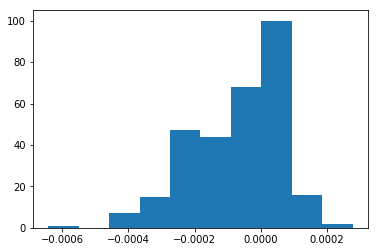

In [309]:
plt.hist(equal_rets)

In [148]:
def retConstShare(retMat, w):
    n, p = retMat.shape
    assert(w.shape == (p,1))
    wSum1 = w/np.sum(w)

    totalRetMat = 1 + retMat

    cummProdd = np.cumprod(totalRetMat, axis = 0)
    navVec = np.matmul(cummProdd, wSum1)

    wEnd = cummProdd[n-1, :]
    wEnd = np.dot(wEnd, w) #since w is (p,1) but wEnd is (1,p)
    wEnd = wEnd/np.sum(wEnd)
    wEnd = wEnd.T

    navVecTot = np.concatenate((np.ones((1,1)), navVec[:(n-1),]))

    totalRetVec = np.divide(navVec, navVecTot)

    retVec = totalRetVec - 1
    retVec = retVec * np.sum(w)

    return retVec